In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_data_frequency_conversor as dfc
import my_models as mm
import my_llm_ts_preprocessor as tsp
#import my_prompting_tool as mpt 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

from nixtla import NixtlaClient
from dotenv import load_dotenv
import os

load_dotenv()  # Carga el .env

from itertools import islice
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset

import sys
from types import ModuleType

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split


In [2]:
#DATA_HOURS = 'DATA/ETHUSD-H1.csv'
#DATA_DAYS = 'DATA/ETHUSD-D1.csv'
DATA_MONTHS = 'DATA/ETHUSD-Monthly.csv'
#arima_h = mm.Model('ARIMA')
#arima_d = mm.Model('ARIMA-d')
arima_m = mm.Model('ARIMA-m')
#exp_smooth_h = mm.Model('EXPONENTIAL SMOOTHING')
#exp_smooth_d = mm.Model('EXPONENTIAL SMOOTHING')
exp_smooth_m = mm.Model('EXPONENTIAL SMOOTHING')
#holt_h = mm.Model('HOLT')
#holt_d = mm.Model('HOLT')
holt_m = mm.Model('HOLT')
#holt_winters_h = mm.Model('HOLT WINTERS')
#holt_winters_d = mm.Model('HOLT WINTERS')
holt_winters_m = mm.Model('HOLT WINTERS')
#timegpt_h = mm.Model('TIMEGPT')
#timegpt_d = mm.Model('TIMEGPT')
timegpt_m = mm.Model('TIMEGPT')
#lagllama_h = mm.Model('LAGLLAMA')
#lagllama_d = mm.Model('LAGLLAMA')
lagllama_m = mm.Model('LAGLLAMA')
#gpt_h = mm.Model('GPT-H')
#gpt_d = mm.Model('GPT-D')
gpt_m = mm.Model('GPT-M')


In [3]:
# Crear una serie de ejemplo
series = [0.123, 1.23, 12.3, 123.0, 1000.0]

# Instanciar el preprocesador
preprocessor = tsp.TimeSeriesPreprocessor(percentile=95)

# Procesar la serie
processed_series = preprocessor.preprocess(series)

print(processed_series)


['0 0 0', '0 0 0', '0 0 1', '0 1 5', '1 2 1']


In [4]:
data_months = pd.read_csv(DATA_MONTHS, delimiter=',')
train_data_months, val_data_months = dfc.split_data(data_months)
train_data_months = train_data_months.asfreq('MS')
val_data_months = val_data_months.asfreq('MS')
print(train_data_months.head())
print(val_data_months.head())

                      y
DateTime               
2021-01-01   736.220000
2021-02-01  1313.868608
2021-03-01  1424.400000
2021-04-01  1919.300000
2021-05-01  2769.400000
                 y
DateTime          
2024-01-01  2286.5
2024-02-01  2283.0
2024-03-01  3339.2
2024-04-01  3650.6
2024-05-01  3020.3


In [5]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

C:\Users\vicde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Convertir la serie en DataFrame con las columnas correctas
arima_m.nixtla_format = dfc.convert_to_nixtla(train_data_months)
print(arima_m.nixtla_format.head())
arima_m.model = StatsForecast(
    models=[AutoARIMA(season_length=1)],
    freq='MS'
)

arima_m.model.fit(arima_m.nixtla_format)
arima_m.forecast = arima_m.model.predict(h=12, level=[95])
print(arima_m.forecast)

          ds            y unique_id
0 2021-01-01   736.220000     Value
1 2021-02-01  1313.868608     Value
2 2021-03-01  1424.400000     Value
3 2021-04-01  1919.300000     Value
4 2021-05-01  2769.400000     Value
   unique_id         ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0      Value 2024-01-01  2041.977347      1060.637520      3023.317174
1      Value 2024-02-01  2032.962850       750.906860      3315.018840
2      Value 2024-03-01  2025.384395       567.741214      3483.027576
3      Value 2024-04-01  2019.013215       449.070571      3588.955858
4      Value 2024-05-01  2013.656986       368.962716      3658.351255
5      Value 2024-06-01  2009.154023       313.614072      3704.693975
6      Value 2024-07-01  2005.368399       274.793017      3735.943781
7      Value 2024-08-01  2002.185838       247.270269      3757.101406
8      Value 2024-09-01  1999.510270       227.593427      3771.427112
9      Value 2024-10-01  1997.260929       213.425816      3781.096043
10 

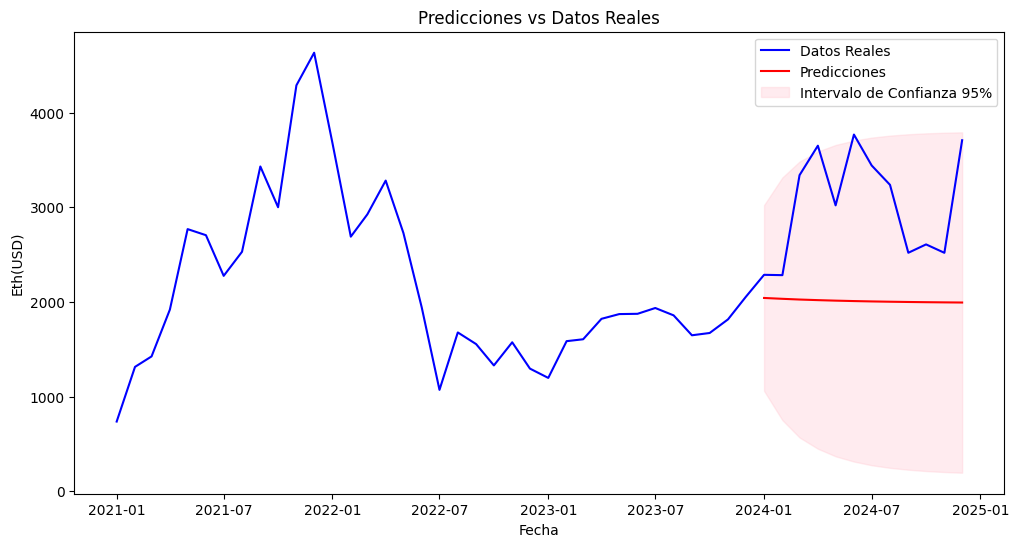

In [7]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_months.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_months.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_m.forecast['ds'], arima_m.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_m.forecast['ds'],
    arima_m.forecast['AutoARIMA-lo-95'],
    arima_m.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Eth(USD)')

# Mostrar la gráfica
plt.show()

In [8]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_m.model = SimpleExpSmoothing(train_data_months).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_m.optimal_alpha = exp_smooth_m.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_m.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_m.forecast = exp_smooth_m.model.forecast(steps=12)
exp_smooth_m.forecast


Alpha óptimo: 0.9950


2024-01-01    2051.5119
2024-02-01    2051.5119
2024-03-01    2051.5119
2024-04-01    2051.5119
2024-05-01    2051.5119
2024-06-01    2051.5119
2024-07-01    2051.5119
2024-08-01    2051.5119
2024-09-01    2051.5119
2024-10-01    2051.5119
2024-11-01    2051.5119
2024-12-01    2051.5119
Freq: MS, dtype: float64

In [9]:
holt_m.model = Holt(train_data_months).fit(optimized=True)
holt_m.optimal_alpha = holt_m.model.model.params["smoothing_level"]
holt_m.optimal_beta = holt_m.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_m.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_m.optimal_beta:.4f}")
holt_m.forecast = holt_m.model.forecast(steps=12)
holt_m.forecast

Alpha óptimo: 0.9950
Beta óptimo: 0.1658


2024-01-01    2098.269056
2024-02-01    2144.981811
2024-03-01    2191.694565
2024-04-01    2238.407320
2024-05-01    2285.120074
2024-06-01    2331.832829
2024-07-01    2378.545583
2024-08-01    2425.258338
2024-09-01    2471.971092
2024-10-01    2518.683847
2024-11-01    2565.396601
2024-12-01    2612.109356
Freq: MS, dtype: float64

In [10]:
# Ajustar el modelo con cálculo óptimo de alpha
holt_winters_m.model = ExponentialSmoothing(train_data_months, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_m.optimal_params = holt_winters_m.model.params
print(f"Parámetros óptimos: {holt_winters_m.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_m.forecast = holt_winters_m.model.forecast(steps=12)
holt_winters_m.forecast

Parámetros óptimos: {'smoothing_level': 0.7295771184078055, 'smoothing_trend': 0.08891954743021457, 'smoothing_seasonal': 0.04388717532434116, 'damping_trend': nan, 'initial_level': 1996.5170596711198, 'initial_trend': 115.752394741769, 'initial_seasons': array([-411.56620059, -366.07547659, -213.29319419,  138.31934471,
        236.62773742,  -61.92491002, -495.27454491, -246.22379542,
        -38.21421983, -237.03039149,  315.77801289,  392.67210637]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


2024-01-01    1179.700345
2024-02-01    1194.793075
2024-03-01    1325.872280
2024-04-01    1657.900018
2024-05-01    1733.362385
2024-06-01    1412.013137
2024-07-01     953.640088
2024-08-01    1172.979345
2024-09-01    1349.368565
2024-10-01    1128.198494
2024-11-01    1653.184052
2024-12-01    1705.007802
Freq: MS, dtype: float64

In [11]:
train_data_months_nixtla = dfc.convert_to_nixtla(train_data_months)

In [ ]:
my_api_key = os.getenv("MY_NIXTLA_API_KEY")
nixtla_client = NixtlaClient(
    api_key = my_api_key
)

timegpt_m.predictions = nixtla_client.forecast(
    train_data_months_nixtla,
    h=12
)

#nixtla_client.plot(train_data_months_nixtla, timegpt_m.predictions)

'''timegpt_d.predictions = nixtla_client.predict(
    df=train_data_days,
    horizon=366,
    time_col='DateTime',
    target_col='Open',
)

timegpt_h.predictions = nixtla_client.predict(
    df=train_data_hours,
    horizon=366*24,
    time_col='DateTime',
    target_col='Open',
)'''


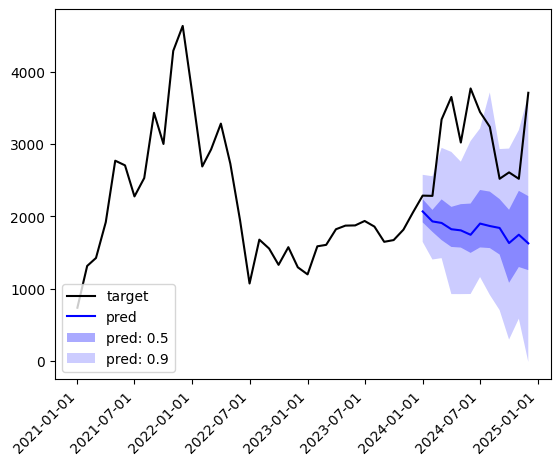

In [12]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast
from uni2ts.model.moirai import MoiraiModule

SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 12  # prediction length: any positive integer
CTX = 12*3  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 12  # test set length: any positive integer

# Convert into GluonTS dataset
df = dfc.convert_to_moirai(data_months)

ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set



# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()


In [ ]:
%pip install chronos-forecasting

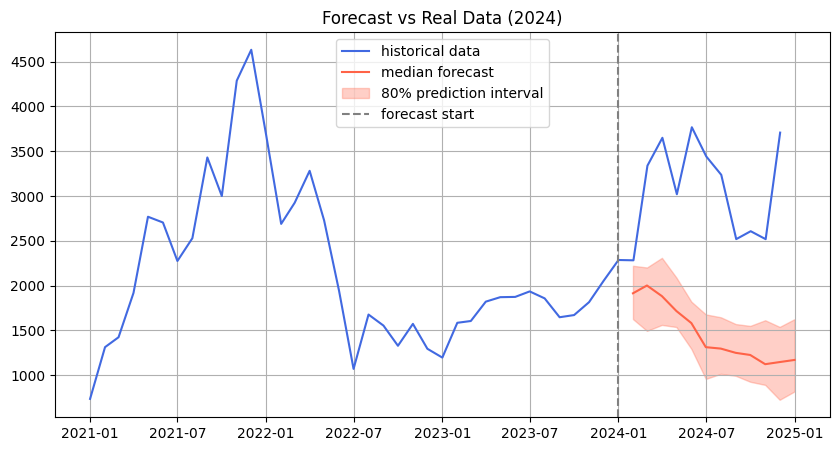

In [ ]:
# Chronos
from chronos import BaseChronosPipeline

# Cargar modelo
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # usa "amazon/chronos-bolt-small" para Chronos-Bolt
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Convertir datos (dfc y data_months deben estar definidos antes)
df = dfc.convert_to_moirai(data_months)

# --- 1. Usar solo datos hasta 2023 para entrenar el contexto ---
df_context = df[df.index < "2024-01-01"]

# Predecir 12 meses (todo 2024)
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_context["y"].values, dtype=torch.float32).unsqueeze(0),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

# --- 2. Construir índice de forecast para 2024 ---
forecast_index = pd.date_range(start="2024-01-01", periods=12, freq="MS")

low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# --- 3. Plotear ---
plt.figure(figsize=(10, 5))

# Datos históricos completos (incluye 2024 real)
plt.plot(df.index, df["y"], color="royalblue", label="historical data")

# Predicción (para 2024)
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.axvline(pd.Timestamp("2024-01-01"), color="gray", linestyle="--", label="forecast start")

plt.legend()
plt.grid()
plt.title("Forecast vs Real Data (2024)")
plt.show()



In [ ]:
# Convertir la serie temporal a lenguaje natural
desp = mpt.paraphrase_initial(gpt_m.name)
train_lan = mpt.paraphrase_seq2lan(train_data_months, desp)

# Realizar la predicción para los próximos 12 meses (1 año)
steps = 12  # Número de meses a predecir
model_name = 'gpt-4o-mini'  
predicted_lan = mpt.paraphrasing_predict_llm(desp, train_lan, steps, model_name)
print(predicted_lan)
# Convertir la predicción en lenguaje natural de vuelta a una serie temporal
predicted_series = mpt.recover_lan2seq(predicted_lan)

# Mostrar la serie temporal predicha
print(predicted_series)

In [ ]:
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")

#login(token=HF_TOKEN)




In [ ]:
from huggingface_hub import InferenceClient

MODEL = "meta-llama/Llama-2-13b"
client = InferenceClient(model=MODEL, token=HF_TOKEN)

prompt = "¿Qué es el aprendizaje automático?"
response = client.text_generation(prompt, max_new_tokens=200)

print(response)
